# Task 2: Landmark Detection on a 3D Facial Point Cloud
## Download AFLW2000-3D dataset:

https://www.kaggle.com/datasets/mohamedadlyi/aflw2000-3d

Inspect dataset:

Keys in mat: dict_keys(['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68'])
Key: pt2d, Shape: (2, 21)
Key: Illum_Para, Shape: (1, 10)
Key: Color_Para, Shape: (1, 7)
Key: Tex_Para, Shape: (199, 1)
Key: Shape_Para, Shape: (199, 1)
Key: Exp_Para, Shape: (29, 1)
Key: Pose_Para, Shape: (1, 7)
Key: roi, Shape: (1, 4)
Key: pt3d_68, Shape: (3, 68)
Shape of mat: (2, 21)


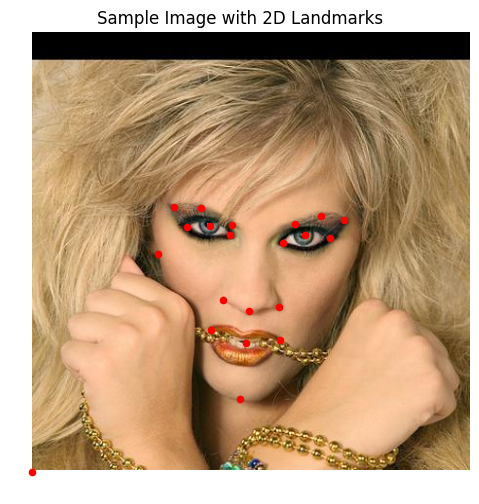

In [40]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from PIL import Image

# Load image and corresponding .mat annotation
img_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00002.jpg'
mat_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00002.mat'

img = Image.open(img_path)
mat = scipy.io.loadmat(mat_path)

#print it's keys and shape of each key
print(f"Keys in mat: {mat.keys()}")
for key in mat.keys():
    if isinstance(mat[key], np.ndarray):
        print(f"Key: {key}, Shape: {mat[key].shape}")

#print shape of mat and example
print(f"Shape of mat: {mat['pt2d'].shape}")  # Example output: (2, 21)

pts_2d = mat['pt2d']  # shape: (2, 21)
# pts_3d = mat['pt3d_68'] # shape: (2, 21)# Shape: (3, 68)

# Plot image with 2D landmarks
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.scatter(pts_2d[0, :], pts_2d[1, :], c='r', s=20)
plt.title('Sample Image with 2D Landmarks')
plt.axis('off')
plt.show()


### Approach for Nose-Tip Detection

We use a simple geometric heuristic: the nose tip is assumed to be the most protruding point along the z-axis in the 3D facial landmarks. We load the 3D landmarks from a sample `.mat` file, identify the point with the maximum z-value, and visualize the result.

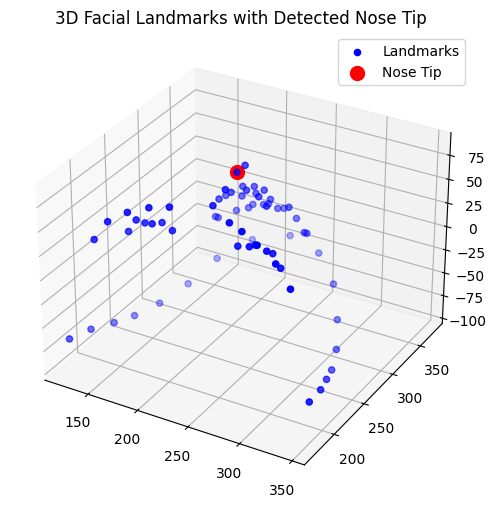

In [41]:
import scipy.io
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

# Load image and corresponding .mat annotation
img_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00002.jpg'
mat_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00002.mat'

img = Image.open(img_path)

# Load a sample .mat file containing 3D landmarks
mat = scipy.io.loadmat(mat_path)
pts_3d = mat['pt3d_68']  # shape: (3, 68)

# Transpose to shape (68, 3) for easier handling
points = pts_3d.T

# Find the nose tip: point with maximum z value
nose_tip_idx = np.argmax(points[:, 2])
nose_tip = points[nose_tip_idx]

# Visualize the 3D landmarks and highlight the nose tip
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', label='Landmarks')
ax.scatter(nose_tip[0], nose_tip[1], nose_tip[2], c='r', s=100, label='Nose Tip')
ax.set_title('3D Facial Landmarks with Detected Nose Tip')
ax.legend()
plt.show()

Visualise 3d landmarks and nose tip detection on an image:

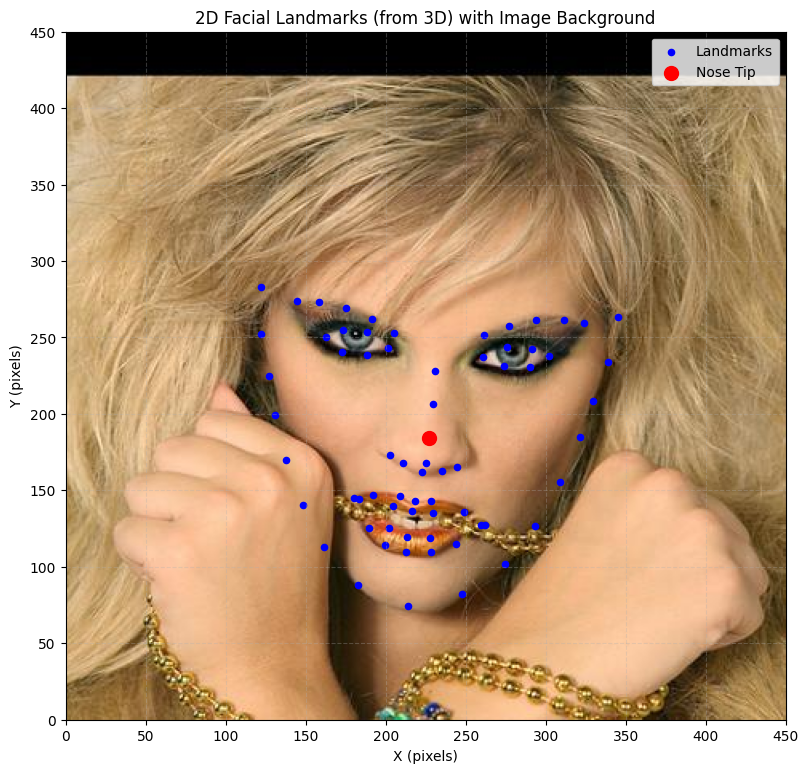

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get image dimensions
if isinstance(img, np.ndarray):
    image_height, image_width = img.shape[0], img.shape[1]
else:
    image_width, image_height = img.size

# Flip Y axis of the points to match image coordinate system (origin='upper')
points_flipped = points.copy()
points_flipped[:, 1] = image_height - points[:, 1]

nose_tip_flipped = nose_tip.copy()
nose_tip_flipped[1] = image_height - nose_tip[1]

# Define extent based on image size
imshow_extent = [0, image_width, 0, image_height]

# Setup figure
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.07)  # add some padding for labels/title

# Show image
ax.imshow(np.array(img), extent=imshow_extent, origin='upper', aspect='auto', zorder=0)

# Plot flipped landmarks
ax.scatter(points_flipped[:, 0], points_flipped[:, 1], c='b', s=20, label='Landmarks', zorder=1)
ax.scatter(nose_tip_flipped[0], nose_tip_flipped[1], c='r', s=100, label='Nose Tip', zorder=2)

# Set axes to match image bounds
ax.set_xlim(0, image_width)
ax.set_ylim(0, image_height)

# Add axis labels and title
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_title('2D Facial Landmarks (from 3D) with Image Background')

# Show grid and legend
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()

plt.show()

## More robust method:
As the face is rotated, the nose tip may not always be the most protruding point in a single axis.

A more robust method would involve doing PCA on the 3D landmarks (axis independent) to find the principal components.

PC1 = longest spread (e.g. ear to ear)

PC2 = vertical spread (chin to forehead)

PC3 = depth (nose protrusion direction)

Flip PC3 if necessary to make it point outward (towards us).

Project points onto PC3 and find the most protruding point (max PC3 projection) as the nose tip.

Visualise PCA method without depth flipping on 2d projection:

Detected Nose Tip (3D): [225.08842 281.8034   83.22617]


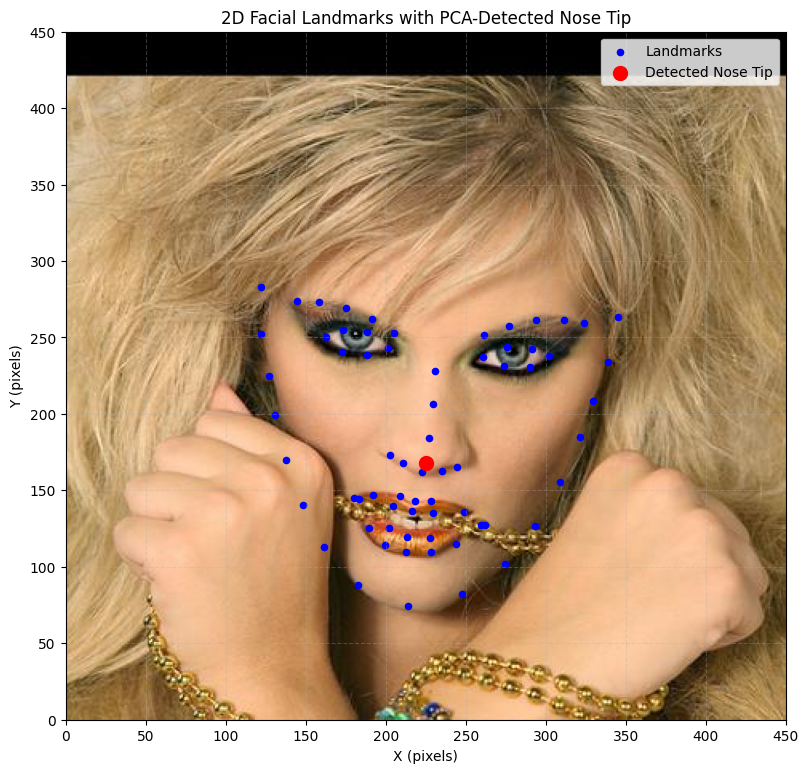

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def detect_nose_tip(points_3d: np.ndarray) -> np.ndarray:
    """
    Detect the nose tip from 3D facial landmarks using PCA.
    
    Args:
        points_3d (np.ndarray): (N, 3) array of 3D points.
    
    Returns:
        np.ndarray: (3,) coordinates of the detected nose tip.
    """
    centered = points_3d - points_3d.mean(axis=0)
    pca = PCA(n_components=3)
    pca.fit(centered)
    components = pca.components_

    pc_depth = components[2]
    projections = centered @ pc_depth

    nose_tip_idx = np.argmax(projections)
    return points_3d[nose_tip_idx]

# --------------- Run PCA detection ---------------
nose_tip_3d = detect_nose_tip(points)
print("Detected Nose Tip (3D):", nose_tip_3d)


# --------------- Plotting 2D Landmarks with Detected Nose Tip ---------------
# Get image dimensions
if isinstance(img, np.ndarray):
    image_height, image_width = img.shape[:2]
else:
    image_width, image_height = img.size

# Flip Y axis for 2D projection
points_flipped = points.copy()
points_flipped[:, 1] = image_height - points[:, 1]

nose_tip_flipped = nose_tip_3d.copy()
nose_tip_flipped[1] = image_height - nose_tip_3d[1]

# Define image extent
imshow_extent = [0, image_width, 0, image_height]

fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.07)

# Show image background
ax.imshow(np.array(img), extent=imshow_extent, origin='upper', aspect='auto', zorder=0)

# Plot landmarks
ax.scatter(points_flipped[:, 0], points_flipped[:, 1], c='b', s=20, label='Landmarks', zorder=1)

# Plot detected nose tip
ax.scatter(nose_tip_flipped[0], nose_tip_flipped[1], c='r', s=100, label='Detected Nose Tip', zorder=2)

# Axes and labels
ax.set_xlim(0, image_width)
ax.set_ylim(0, image_height)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_title('2D Facial Landmarks with PCA-Detected Nose Tip')
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()

plt.show()


Interactive 3D visualisation of PCA, showing the nose tip detection and component directions:

In [44]:
import scipy.io
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# Load image and corresponding .mat annotation
img_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00150.jpg'
mat_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00150.mat'

img = Image.open(img_path)

# Load a sample .mat file containing 3D landmarks
mat = scipy.io.loadmat(mat_path)
pts_3d = mat['pt3d_68']  # shape: (3, 68)

# Transpose to shape (68, 3) for easier handling
points = pts_3d.T

def detect_nose_tip_PCA(points_3d: np.ndarray) -> np.ndarray:
    centered = points_3d - points_3d.mean(axis=0)
    pca = PCA(n_components=3)
    pca.fit(centered)
    components = pca.components_
    pc_depth = components[2]
    projections = centered @ pc_depth
    nose_tip_idx = np.argmax(projections)
    return points_3d[nose_tip_idx]

# Detect nose tip using the previously defined function
nose_tip = detect_nose_tip_PCA(points)

# Perform PCA to get components for visualization
mean_points = points.mean(axis=0)
centered_points = points - mean_points
pca_visualization = PCA(n_components=3)
pca_visualization.fit(centered_points)
components = pca_visualization.components_
explained_variance_ratio = pca_visualization.explained_variance_ratio_

# Create a 3D scatter plot using Plotly
fig = go.Figure()

# Add landmarks
fig.add_trace(go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Landmarks'
))

# Add the detected nose tip
fig.add_trace(go.Scatter3d(
    x=[nose_tip[0]],
    y=[nose_tip[1]],
    z=[nose_tip[2]],
    mode='markers',
    marker=dict(size=10, color='red', symbol='cross'),
    name='Detected Nose Tip'
))

# Add principal component vectors to the plot
pc_colors = ['green', 'orange', 'purple'] # Colors for PC1, PC2, PC3
for i, component in enumerate(components):
    # Scale component for visibility. You can adjust the scale_factor.
    # Using explained variance ratio to scale, making more important components longer.
    scale_factor = 50 * explained_variance_ratio[i] * 3 # Adjusted scale factor

    fig.add_trace(go.Scatter3d(
        x=[mean_points[0], mean_points[0] + component[0] * scale_factor],
        y=[mean_points[1], mean_points[1] + component[1] * scale_factor],
        z=[mean_points[2], mean_points[2] + component[2] * scale_factor],
        mode='lines',
        line=dict(color=pc_colors[i], width=6),
        name=f'PC{i+1} (Var: {explained_variance_ratio[i]:.2f})'
    ))

# Update layout for better visualization
fig.update_layout(
    title='3D Facial Landmarks, Nose Tip, and Principal Components',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data' # Ensures aspect ratio is preserved
    ),
    legend=dict(x=0, y=1),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()

PCA depth direction correction as some are initalised with PC3 pointing inward:

In [45]:
import scipy.io
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# Load image and corresponding .mat annotation
img_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00150.jpg'
mat_path = r'C:\Users\giles\Github\vesselFM\AFLW2000\image00150.mat'

img = Image.open(img_path)

# Load a sample .mat file containing 3D landmarks
mat = scipy.io.loadmat(mat_path)
pts_3d = mat['pt3d_68']  # shape: (3, 68)

# Transpose to shape (68, 3) for easier handling
points = pts_3d.T

def orient_facial_pca_components(
    pca_components: np.ndarray,
    centered_landmarks: np.ndarray,
    original_landmarks: np.ndarray,
    original_landmarks_mean: np.ndarray,
    min_points_for_spread_calc: int = 5
) -> np.ndarray:
    """
    Orients the principal components of facial landmarks, ensuring PC3 points "outward".

    Args:
        pca_components (np.ndarray): (3, 3) array of principal components.
        centered_landmarks (np.ndarray): (N, 3) array of mean-centered landmarks.
        original_landmarks (np.ndarray): (N, 3) array of original landmarks.
        original_landmarks_mean (np.ndarray): (3,) mean of the original landmarks.
        min_points_for_spread_calc (int): Min points for spread heuristic.

    Returns:
        np.ndarray: (3, 3) array of components with PC3 (components[2]) oriented.
    """
    corrected_components = pca_components.copy()
    pc_depth_original = pca_components[2].copy()
    # In this cell's original logic, pc_compare_axis was components[0]
    pc_compare_axis = pca_components[1].copy()
    pc_depth_final = pc_depth_original.copy()

    new_heuristic_applied = False
    # Calculate projections of centered landmarks on the original PC3
    centered_projections_on_pc_depth = centered_landmarks @ pc_depth_original
    front_indices = np.where(centered_projections_on_pc_depth > 1e-6)[0]
    behind_indices = np.where(centered_projections_on_pc_depth < -1e-6)[0]

    if len(front_indices) >= min_points_for_spread_calc and \
       len(behind_indices) >= min_points_for_spread_calc:
        
        projections_front_group_on_compare_axis = centered_landmarks[front_indices] @ pc_compare_axis
        projections_behind_group_on_compare_axis = centered_landmarks[behind_indices] @ pc_compare_axis
        # Calculate spread (standard deviation) of projections
        spread_front_group = np.std(projections_front_group_on_compare_axis)
        spread_behind_group = np.std(projections_behind_group_on_compare_axis)
        # If the spread of the front group is greater than the behind group, flip PC3
        if spread_front_group > spread_behind_group:
            pc_depth_final = -pc_depth_original
        new_heuristic_applied = True
    # fallback to the original logic if the new heuristic is not applied
    if not new_heuristic_applied:
        initial_max_z_point = original_landmarks[np.argmax(original_landmarks[:, 2])]
        reference_outward_vector = initial_max_z_point - original_landmarks_mean
        if np.linalg.norm(reference_outward_vector) > 1e-6:
            if np.dot(pc_depth_original, reference_outward_vector) < 0:
                pc_depth_final = -pc_depth_original
    
    corrected_components[2] = pc_depth_final
    return corrected_components

def detect_nose_tip_PCA_direction(points_3d: np.ndarray) -> np.ndarray:
    """
    Detect the nose tip from 3D facial landmarks using PCA,
    ensuring the depth component points outward using a spread-based rule (larger landmark density at the front).

    Args:
        points_3d (np.ndarray): (N, 3) array of 3D points.

    Returns:
        np.ndarray: (3,) coordinates of the detected nose tip.
    """
    mean_landmarks = points_3d.mean(axis=0)
    centered = points_3d - mean_landmarks

    pca = PCA(n_components=3)
    pca.fit(centered)

    # Get oriented components
    corrected_components = orient_facial_pca_components(
        pca.components_, centered, points_3d, mean_landmarks, min_points_for_spread_calc=5
    )
    pc_depth_final = corrected_components[2]

    # Project the centered points onto the finalized (correctly oriented) pc_depth_final
    projections = centered @ pc_depth_final

    # The nose tip is the point with the largest projection along this outward pc_depth_final
    nose_tip_idx = np.argmax(projections)

    return points_3d[nose_tip_idx]


# Detect nose tip using the previously defined function
nose_tip = detect_nose_tip_PCA_direction(points)

# Perform PCA to get components for visualization
mean_points_viz = points.mean(axis=0)
centered_points_viz = points - mean_points_viz
pca_visualization = PCA(n_components=3)
pca_visualization.fit(centered_points_viz)
original_components_for_plot = pca_visualization.components_.copy() # Get the original components from pca_visualization
explained_variance_ratio = pca_visualization.explained_variance_ratio_

# ---- Start: Logic to determine if PC3 for plotting should be flipped ----
components_to_plot_corrected = orient_facial_pca_components(
    original_components_for_plot,
    centered_points_viz,
    points,             # original_landmarks for plotting
    mean_points_viz     # original_landmarks_mean for plotting
)
# ---- End: Logic to determine if PC3 for plotting should be flipped ----


# Create a 3D scatter plot using Plotly
fig = go.Figure()

# Add landmarks
fig.add_trace(go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Landmarks'
))

# Add the detected nose tip
fig.add_trace(go.Scatter3d(
    x=[nose_tip[0]],
    y=[nose_tip[1]],
    z=[nose_tip[2]],
    mode='markers',
    marker=dict(size=10, color='red', symbol='cross'),
    name='Detected Nose Tip'
))

# Add principal component vectors to the plot
pc_colors = ['green', 'orange', 'purple'] # Colors for PC1, PC2, PC3
for i, component in enumerate(components_to_plot_corrected): # Use the corrected components
    # Scale component for visibility. You can adjust the scale_factor.
    # Using explained variance ratio to scale, making more important components longer.
    scale_factor = 50 * explained_variance_ratio[i] * 3 # Adjusted scale factor
    
    fig.add_trace(go.Scatter3d(
        x=[mean_points[0], mean_points[0] + component[0] * scale_factor],
        y=[mean_points[1], mean_points[1] + component[1] * scale_factor],
        z=[mean_points[2], mean_points[2] + component[2] * scale_factor],
        mode='lines',
        line=dict(color=pc_colors[i], width=6),
        name=f'PC{i+1} (Var: {explained_variance_ratio[i]:.2f})'
    ))

# Update layout for better visualization
fig.update_layout(
    title='3D Facial Landmarks, Nose Tip, and Principal Components',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data' # Ensures aspect ratio is preserved
    ),
    legend=dict(x=0, y=1),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()

## Evaluation

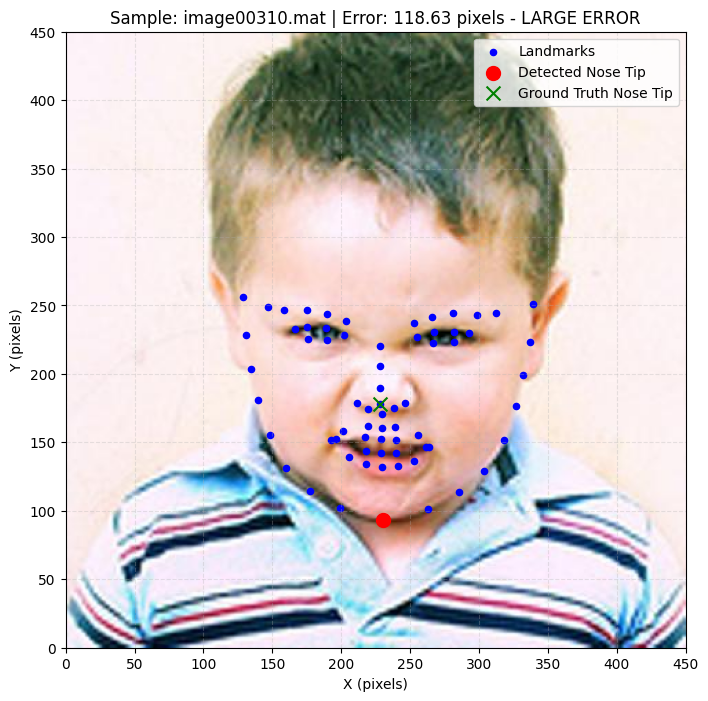

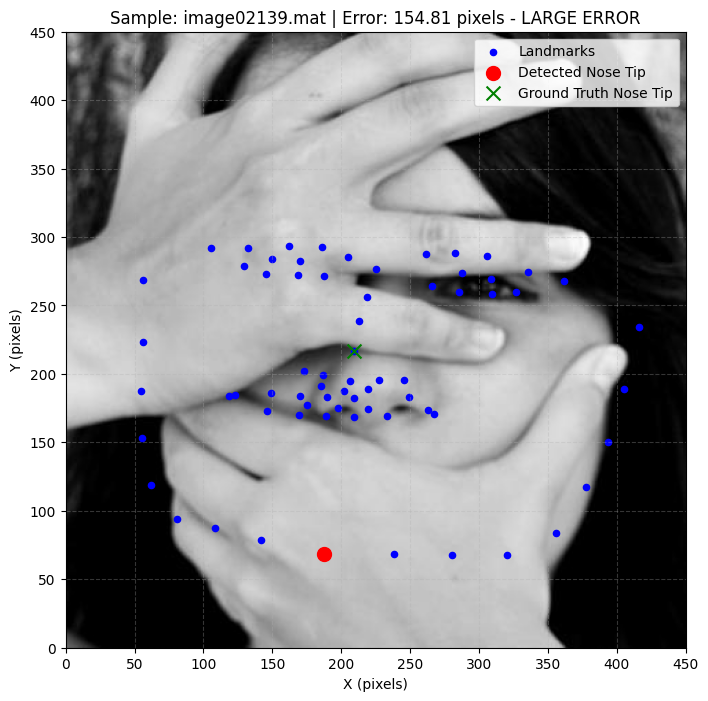

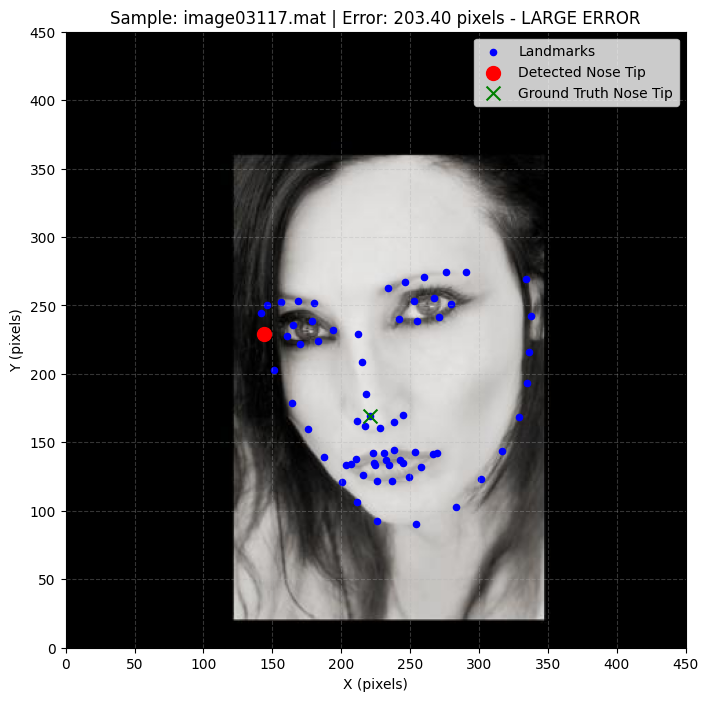

Processed 2000 samples
Mean distance error: 0.5972
Median distance error: 0.0000
Max distance error: 203.3960
Correct: 1976 out of 2000
Accuracy: 0.988
Total evaluation time: 3.40 seconds


In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.io import loadmat
from PIL import Image  # if you load images this way
import time # Added import


def orient_facial_pca_components(
    pca_components: np.ndarray,
    centered_landmarks: np.ndarray,
    original_landmarks: np.ndarray,
    original_landmarks_mean: np.ndarray,
    min_points_for_spread_calc: int = 5
) -> np.ndarray:
    """
    Orients the principal components of facial landmarks, ensuring PC3 points "outward".

    Args:
        pca_components (np.ndarray): (3, 3) array of principal components.
        centered_landmarks (np.ndarray): (N, 3) array of mean-centered landmarks.
        original_landmarks (np.ndarray): (N, 3) array of original landmarks.
        original_landmarks_mean (np.ndarray): (3,) mean of the original landmarks.
        min_points_for_spread_calc (int): Min points for spread heuristic.

    Returns:
        np.ndarray: (3, 3) array of components with PC3 (components[2]) oriented.
    """
    corrected_components = pca_components.copy()
    pc_depth_original = pca_components[2].copy()
    # In this cell's original logic, pc_compare_axis was components[0]
    pc_compare_axis = pca_components[1].copy()
    pc_depth_final = pc_depth_original.copy()

    new_heuristic_applied = False
    # Calculate projections of centered landmarks on the original PC3
    centered_projections_on_pc_depth = centered_landmarks @ pc_depth_original
    front_indices = np.where(centered_projections_on_pc_depth > 1e-6)[0]
    behind_indices = np.where(centered_projections_on_pc_depth < -1e-6)[0]

    if len(front_indices) >= min_points_for_spread_calc and \
       len(behind_indices) >= min_points_for_spread_calc:
        
        projections_front_group_on_compare_axis = centered_landmarks[front_indices] @ pc_compare_axis
        projections_behind_group_on_compare_axis = centered_landmarks[behind_indices] @ pc_compare_axis
        # Calculate spread (standard deviation) of projections
        spread_front_group = np.std(projections_front_group_on_compare_axis)
        spread_behind_group = np.std(projections_behind_group_on_compare_axis)
        # If the spread of the front group is greater than the behind group, flip PC3
        if spread_front_group > spread_behind_group:
            pc_depth_final = -pc_depth_original
        new_heuristic_applied = True
    # fallback to the original logic if the new heuristic is not applied
    if not new_heuristic_applied:
        initial_max_z_point = original_landmarks[np.argmax(original_landmarks[:, 2])]
        reference_outward_vector = initial_max_z_point - original_landmarks_mean
        if np.linalg.norm(reference_outward_vector) > 1e-6:
            if np.dot(pc_depth_original, reference_outward_vector) < 0:
                pc_depth_final = -pc_depth_original
    
    corrected_components[2] = pc_depth_final
    return corrected_components

def detect_nose_tip_PCA_direction(points_3d: np.ndarray) -> np.ndarray:
    """
    Detect the nose tip from 3D facial landmarks using PCA,
    ensuring the depth component points outward using a spread-based rule (larger landmark density at the front).

    Args:
        points_3d (np.ndarray): (N, 3) array of 3D points.

    Returns:
        np.ndarray: (3,) coordinates of the detected nose tip.
    """
    mean_landmarks = points_3d.mean(axis=0)
    centered = points_3d - mean_landmarks

    pca = PCA(n_components=3)
    pca.fit(centered)

    # Get oriented components
    # Note: original_landmarks is points_3d, original_landmarks_mean is mean_landmarks
    corrected_components = orient_facial_pca_components(
        pca.components_, centered, points_3d, mean_landmarks, min_points_for_spread_calc=5
    )
    pc_depth_final = corrected_components[2]

    # Project the centered points onto the finalized (correctly oriented) pc_depth_final
    projections = centered @ pc_depth_final

    # The nose tip is the point with the largest projection along this outward pc_depth_final
    nose_tip_idx = np.argmax(projections)

    return points_3d[nose_tip_idx]

def detect_nose_tip_PCA(points_3d: np.ndarray) -> np.ndarray:
    """
    Detect the nose tip from 3D facial landmarks using PCA.
    Args:
        points_3d (np.ndarray): (N, 3) array of 3D points.
    Returns:
        np.ndarray: (3,) coordinates of the detected nose tip.
    """
    centered = points_3d - points_3d.mean(axis=0)
    pca = PCA(n_components=3)
    pca.fit(centered)
    components = pca.components_
    pc_depth = components[2]
    projections = centered @ pc_depth
    nose_tip_idx = np.argmax(projections)
    return points_3d[nose_tip_idx]

def detect_nose_tip_simple(points_3d: np.ndarray) -> np.ndarray:
    """
    Simple heuristic to detect nose tip based on maximum
    z-coordinate in 3D points.
    Args:
        points_3d (np.ndarray): (N, 3) array of 3D points.
    Returns:
        np.ndarray: (3,) coordinates of the detected nose tip.
    """
    # Find the nose tip: point with maximum z value
    nose_tip_idx = np.argmax(points_3d[:, 2])
    nose_tip = points_3d[nose_tip_idx]
    return nose_tip

def plot_landmarks_with_image_fixed(points_3d, detected_tip, gt_tip, img=None, title=""):
    points_2d = points_3d[:, :2]
    if isinstance(img, np.ndarray):
        h, w = img.shape[:2]
    else:
        w, h = img.size

    points_flipped = points_2d.copy()
    points_flipped[:, 1] = h - points_2d[:, 1]

    detected_2d = detected_tip[:2].copy()
    detected_2d[1] = h - detected_2d[1]

    gt_2d = gt_tip[:2].copy()
    gt_2d[1] = h - gt_2d[1]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, extent=[0, w, 0, h], origin='upper', aspect='auto', zorder=0)

    ax.scatter(points_flipped[:, 0], points_flipped[:, 1], c='blue', s=20, label='Landmarks', zorder=1)
    ax.scatter(detected_2d[0], detected_2d[1], c='red', s=100, label='Detected Nose Tip', zorder=2)
    ax.scatter(gt_2d[0], gt_2d[1], c='green', s=100, label='Ground Truth Nose Tip', zorder=3, marker='x')

    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()

def load_image_for_sample(sample_path):
    img_path = os.path.splitext(sample_path)[0] + '.jpg'
    return Image.open(img_path)

def evaluate_nose_tip_detection(mat_file_paths, threshold=15.0):
    """
    Args:
        mat_file_paths (list of str): paths to AFLW2000-3D .mat files
        threshold (float): Euclidean distance threshold in pixels to flag error
    
    Assumes:
        - pt3d_68 key contains (3, 68) array of landmarks
        - nose tip GT is known (use landmark #30 in AFLW dataset as GT nose tip index)
        - Corresponding face image exists for visualization
    """
    distances = []
    start_time = time.time() # Added start time
    for mat_path in mat_file_paths:
        data = loadmat(mat_path)
        pts_3d = data['pt3d_68'].T  # shape (68, 3)

        # Ground truth nose tip: AFLW nose tip is landmark index 30 (0-based)
        nose_tip_gt = pts_3d[30]

        # Detect nose tip
        detected_tip = detect_nose_tip_PCA_direction(pts_3d) #Set detector method here

        # Load corresponding image
        img = load_image_for_sample(mat_path)

        # Calculate Euclidean distance between detected and GT nose tip in 3D
        dist = np.linalg.norm(detected_tip - nose_tip_gt)
        distances.append(dist)

        if dist > threshold:
            # Prepare title with info
            title = f"Sample: {os.path.basename(mat_path)} | Error: {dist:.2f} pixels"
            title += " - LARGE ERROR"
            # Plot results
            plot_landmarks_with_image_fixed(pts_3d, detected_tip, nose_tip_gt, img, title=title)
    
    end_time = time.time() # Added end time
    duration = end_time - start_time # Calculated duration
    
    # Print overall statistics
    distances = np.array(distances)
    print(f"Processed {len(mat_file_paths)} samples")
    print(f"Mean distance error: {distances.mean():.4f}")
    print(f"Median distance error: {np.median(distances):.4f}")
    print(f"Max distance error: {distances.max():.4f}")
    print(f"Correct: {np.count_nonzero(distances == 0)} out of {len(distances)}")
    print(f"Accuracy: {np.count_nonzero(distances == 0)/len(distances)}")
    print(f"Total evaluation time: {duration:.2f} seconds") # Added print for duration


data_folder = r"C:\Users\giles\Github\vesselFM\AFLW2000"
mat_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.mat')]
evaluate_nose_tip_detection(mat_files, threshold=100.0)

### Documentation

**Approach:**

Firstly, we detect the nose tip by selecting the 3D landmark with the highest z-coordinate, assuming it is the most protruding point on the face.

Secondly, we apply PCA to the 3D landmarks to find the principal components and identify the nose tip based on the maximum projection onto the depth component.

Thirdly, we do depth component correction to the PCA approach to ensure the depth component points outward by doing a comparison of the "spread" of the points at the front and behind.

**Performance:**
The evaluation time was measured without any error threshold sample plotting.

| Method:                  | Mean distance error | Max distance error | Accuracy | Total evaluation time (s) | Per point cloud (s) |
|--------------------------|---------------------|--------------------|----------|---------------------------|---------------------|
| Max Z                    | 48.2591             | 216.5532           | 0.447    | 1.41                      | 0.000705            |
| PCA                      | 22.4034             | 318.898            | 0.8605   | 2.28                      | 0.00114             |
| PCA direction correction | 0.5972              | 203.396            | 0.988    | 2.83                      | 0.001415            |



**Challenges:**
- The simple Z max heuristic may fail if the face is rotated or if the nose is not the most protruding point.
- PCA by itself can also fail if the depth component is not oriented correctly, leading to incorrect nose tip detection.
- PCA depth correction had most error with datapoints with strange proportions: wide faces or deep faces such as in young children, 
and also where the face is largely obstructed (eg. by hands, hair, etc). Also where the 3d points are not alined with the jaw line correctly 
(could possibly stem from low image resolution or dataset generation issues).


### Future Work
- With a better quality dataset the performance metrics could be improved such as in the case of landmark detection using multiple images of the same face,
 as many of the incorrectly identified samples (by the final method) were of low quality or had poor landmark detection.
- Alternatively, machine learning methods could be trained for nose tip detection, however this might not offer significant improvements over the PCA method in terms of accuracy or runtime efficiency.
- Machine learning methods could also use the images as well as the 3d landmark data (multi-modal) that might improve robustness against bad landmark detection.
- Machine learning methods could also use the PCA components as features to improve robustness against face rotations and occlusions.